In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

c:\Users\giada\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv("../data/Hepatitis_eda.csv")
df

,Unnamed: 0,Country,Time,Gender,Age,Chronic_percentage,Acute_percentage
0,0,Austria,2008,Female,0-4,0.00,0.00
1,1,Austria,2008,Female,15-19,0.00,10.92
2,2,Austria,2008,Female,20-24,0.00,2.08
3,3,Austria,2008,Female,25-34,0.00,11.96
4,4,Austria,2008,Female,35-44,0.00,7.28
...,...,...,...,...,...,...,...
8203,9499,United Kingdom,2019,Male,35-44,1.53,11.59
8204,9500,United Kingdom,2019,Male,45-54,0.90,12.20
8205,9501,United Kingdom,2019,Male,5-14,0.00,0.00
8206,9502,United Kingdom,2019,Male,55-64,0.45,9.15


In [3]:
# imputing the missing values of chronic percentage for France
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
df['Chronic_percentage'] = imputer.fit_transform(df[['Chronic_percentage']])


In [4]:
# Encoding categorical variables 

label_encoder_country = LabelEncoder()
df['Country'] = label_encoder_country.fit_transform(df['Country'])
label_encoder_gender = LabelEncoder()
df['Gender'] = label_encoder_gender.fit_transform(df['Gender'])
age_mapping = {
    '0-4': 0,
    '15-19': 2,
    '20-24': 3,
    '25-34': 4,
    '35-44': 5,
    '45-54': 6,
    '5-14': 1,
    '55-64': 7,
    '65+': 8
}
df['Age'] = df['Age'].map(age_mapping)

'''label_encoder_age = LabelEncoder()
df['Age'] = label_encoder_age.fit_transform(df['Age'])
'''
# Verify
df.head()



,Unnamed: 0,Country,Time,Gender,Age,Chronic_percentage,Acute_percentage
0,0,0,2008,0,0,0.0,0.00
1,1,0,2008,0,2,0.0,10.92
2,2,0,2008,0,3,0.0,2.08
3,3,0,2008,0,4,0.0,11.96
4,4,0,2008,0,5,0.0,7.28


In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)


In [6]:
# Select features and targets
X = df[['Country', 'Time', 'Gender', 'Age']]
y_chronic = df['Chronic_percentage']  
y_acute = df['Acute_percentage']  



In [7]:
# separate train-test
X_train, X_test, y_train_chronic, y_test_chronic = train_test_split(X, y_chronic, test_size=0.2, random_state=42)
X_train, X_test, y_train_acute, y_test_acute = train_test_split(X, y_acute, test_size=0.2, random_state=42)

In [8]:
# Create and train Random Forest model for Chronic_percentage
rf_chronic = RandomForestRegressor(n_estimators=100, random_state=42)
rf_chronic.fit(X_train, y_train_chronic)

# Create and train Random Forest model for Acute_percentage
rf_acute = RandomForestRegressor(n_estimators=100, random_state=42)
rf_acute.fit(X_train, y_train_acute)

RandomForestRegressor(random_state=42)

In [10]:
import joblib 

models = {
    'chronic': rf_chronic,
    'acute': rf_acute
}

# Salva il dizionario in un unico file
joblib.dump(models, 'models_rf.pkl')

joblib.dump(label_encoder_country, "label_encoder_country.pkl")
joblib.dump(label_encoder_gender, "label_encoder_gender.pkl")
#joblib.dump(label_encoder_age, "label_encoder_age.pkl")
print("Label encoders saved!")


Label encoders saved!


In [ ]:
# Evaluate models
chronic_preds = rf_chronic.predict(X_test)
acute_preds = rf_acute.predict(X_test)

In [ ]:
import numpy as np

# Calculate root mean squared error (RMSE)
rmse_chronic = np.sqrt(mean_squared_error(y_test_chronic, chronic_preds))
rmse_acute = np.sqrt(mean_squared_error(y_test_acute, acute_preds))

print(f'RMSE for Chronic_percentage: {rmse_chronic}')
print(f'RMSE for Acute_percentage: {rmse_acute}')

RMSE for Chronic_percentage: 0.30052233672026496
RMSE for Acute_percentage: 4.646412202336281


#### RMSE (root mean squared error) measures the accuracy of a model's predictions. It calculates the average difference between the predicted values and the actual values, giving more weight to larger errors due to the squaring. Lower RMSE values indicate better model performance. 

In [ ]:
# Predict new data (ex. Austria)
X_new = pd.DataFrame({
    'Country': [label_encoder_country.transform(['Austria'])[0]],  
    'Time': [2020],  
    'Gender': [label_encoder_gender.transform(['Female'])[0]],  
    'Age': [label_encoder_age.transform(['25-34'])[0]] 
})


In [ ]:
# Predict new datas
chronic_new_prediction = rf_chronic.predict(X_new)
acute_new_prediction = rf_acute.predict(X_new)

print(f'Chronic_percentage for Austria, female, 25-34 yo, 2020: {chronic_new_prediction[0]}')
print(f'Acute_percentage for Austria, female, 25-34 yo, 2020: {acute_new_prediction[0]}')

Chronic_percentage for Austria, female, 25-34 yo, 2020: 0.17269999999999988
Acute_percentage for Austria, female, 25-34 yo, 2020: 6.110000000000001


In [ ]:
# Evaluate
y_pred_chronic = rf_chronic.predict(X_test)
y_pred_acute = rf_acute.predict(X_test)


In [ ]:
# Calculate R^2 score
from sklearn.metrics import r2_score

# (R^2)
r2_chronic = r2_score(y_test_chronic, y_pred_chronic)
r2_acute = r2_score(y_test_acute, y_pred_acute)

# 
print(f"R^2 for Chronic: {r2_chronic}")
print(f"R^2 for Acute: {r2_acute}")


R^2 for Chronic: 0.8912318821626068
R^2 for Acute: 0.43947175814264205


In [ ]:
from sklearn.metrics import mean_absolute_error

# MAE
mae_chronic = mean_absolute_error(y_test_chronic, y_pred_chronic)
mae_acute = mean_absolute_error(y_test_acute, y_pred_acute)

print(f"MAE for Chronic: {mae_chronic}")
print(f"MAE for Acute: {mae_acute}")


MAE for Chronic: 0.09422574737696862
MAE for Acute: 2.457349208282582


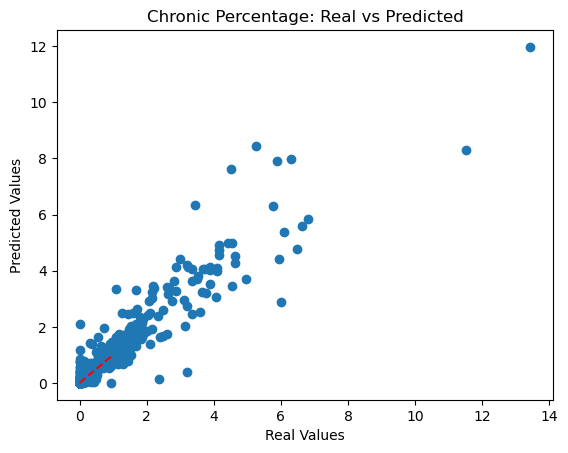

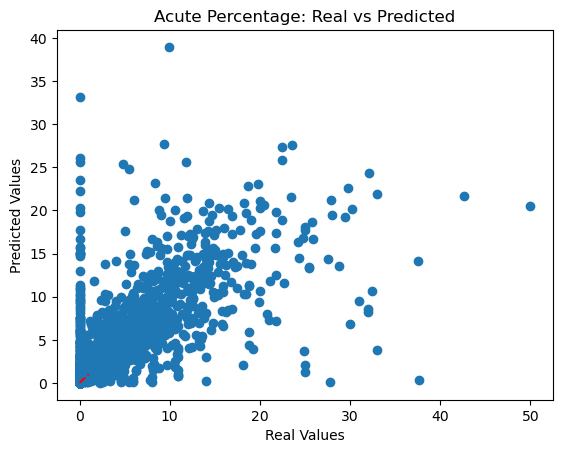

In [ ]:
import matplotlib.pyplot as plt

# Chronic_percentage scatterplot
plt.scatter(y_test_chronic, y_pred_chronic)
plt.plot([0, 1], [0, 1], '--', color='red')  # Identity line (y = x)
plt.title('Chronic Percentage: Real vs Predicted')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.show()

# Acute_percentage scatterplot
plt.scatter(y_test_acute, y_pred_acute)
plt.plot([0, 1], [0, 1], '--', color='red')  # identity line (y = x)
plt.title('Acute Percentage: Real vs Predicted')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.show()


In [ ]:
# print mapping for encoded values 
for i, country in enumerate(label_encoder_country.classes_):
    print(f"{country} -> {i}")

for i, age in enumerate(label_encoder_age.classes_):
    print(f"{age} -> {i}")



Austria -> 0
Croatia -> 1
Cyprus -> 2
Czechia -> 3
Denmark -> 4
Estonia -> 5
Finland -> 6
France -> 7
Germany -> 8
Greece -> 9
Hungary -> 10
Iceland -> 11
Ireland -> 12
Italy -> 13
Latvia -> 14
Liechtenstein -> 15
Lithuania -> 16
Luxembourg -> 17
Malta -> 18
Netherlands -> 19
Norway -> 20
Poland -> 21
Portugal -> 22
Romania -> 23
Slovakia -> 24
Slovenia -> 25
Spain -> 26
Sweden -> 27
United Kingdom -> 28
0-4 -> 0
15-19 -> 1
20-24 -> 2
25-34 -> 3
35-44 -> 4
45-54 -> 5
5-14 -> 6
55-64 -> 7
65+ -> 8
